In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\anaconda\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Random generation of time series with linear dependencies

In [4]:
length = 100000
train_length = 80000

In [5]:
max_lag = 250
min_number_of_ts = 5
max_number_of_ts = 15
coefficients_scaling = 0.4
number_of_experiments = 10

In [6]:
def generate_timeseries(n_experiments):
    result_ts = []
    targets = []
    configs = []
    for i in range(n_experiments):
        np.random.seed(i*100)
        n_ts = np.random.randint(min_number_of_ts, max_number_of_ts+1)
        X = np.random.randn(length, n_ts)
        regr_dict = {}
        lags_dict = {}
        sign_dict = {}
        coef_dict = {}
        for i in range(n_ts):
            n_coupled = np.random.randint(0, n_ts)
            regressors = np.random.choice(np.arange(0, n_ts), n_coupled, replace=False)
            regr_dict[i] = regressors
            lags = np.random.choice(np.arange(1, max_lag), n_coupled, replace=False)
            lags_dict[i] = lags
            sign_dict[i] = []
            for k in range(n_coupled):
                sign = np.random.randint(0, 2)
                sign = sign*2 - 1
                sign_dict[i].append(sign)
            coefs = np.random.rand(n_coupled)*coefficients_scaling
            coef_dict[i] = coefs
            
        for j in range(length):
            for i in range(n_ts):
                for regr, lag, sign, coef in zip(regr_dict[i], lags_dict[i], sign_dict[i], coef_dict[i]):
                    X[j, i] += sign*coef*X[j-lag, regr]
        result_ts.append(X)
        target = np.random.randint(0, n_ts)
        while len(regr_dict[target]) == 0:
            target = np.random.randint(0, n_ts)
        targets.append(target)
        configs.append([regr_dict, lags_dict, sign_dict, coef_dict])
    return result_ts, targets, configs

In [7]:
Xs, targets, configs = generate_timeseries(number_of_experiments)

### Examples of generated time series


0 0


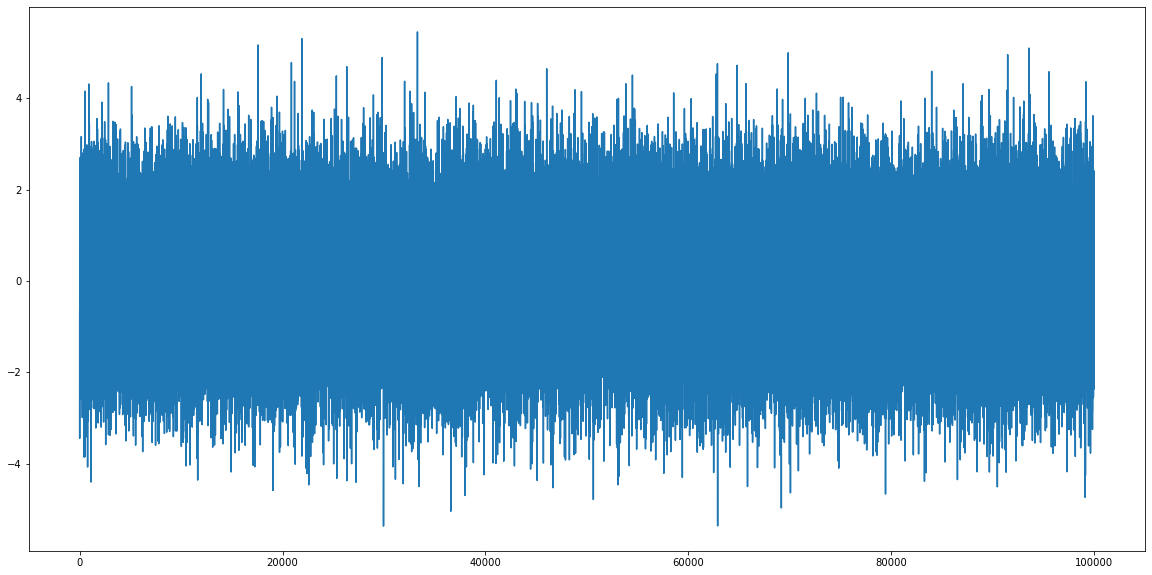

1 0


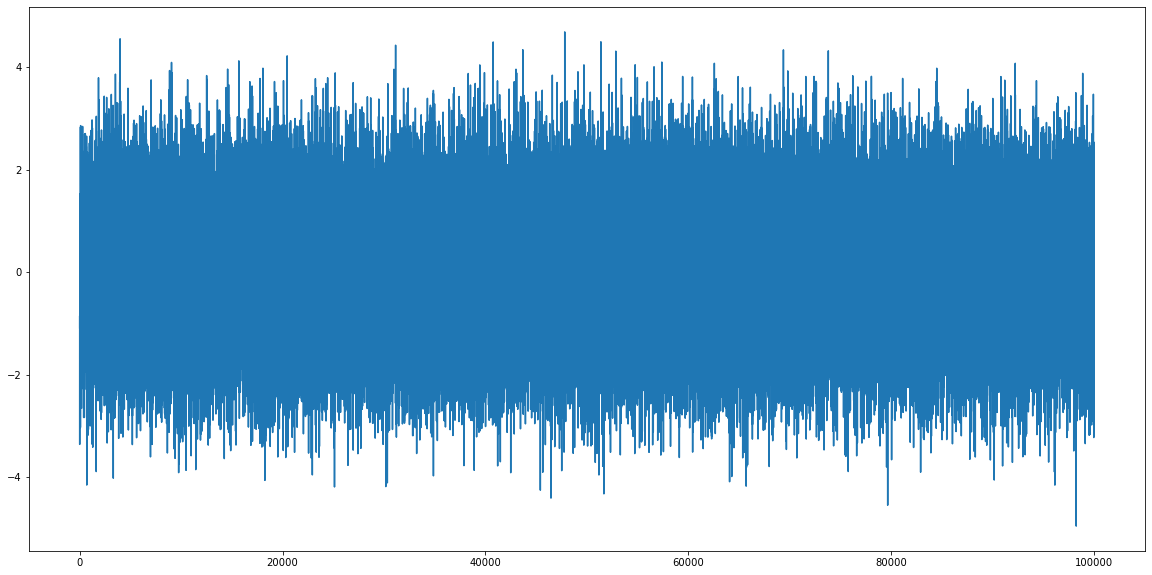

2 0


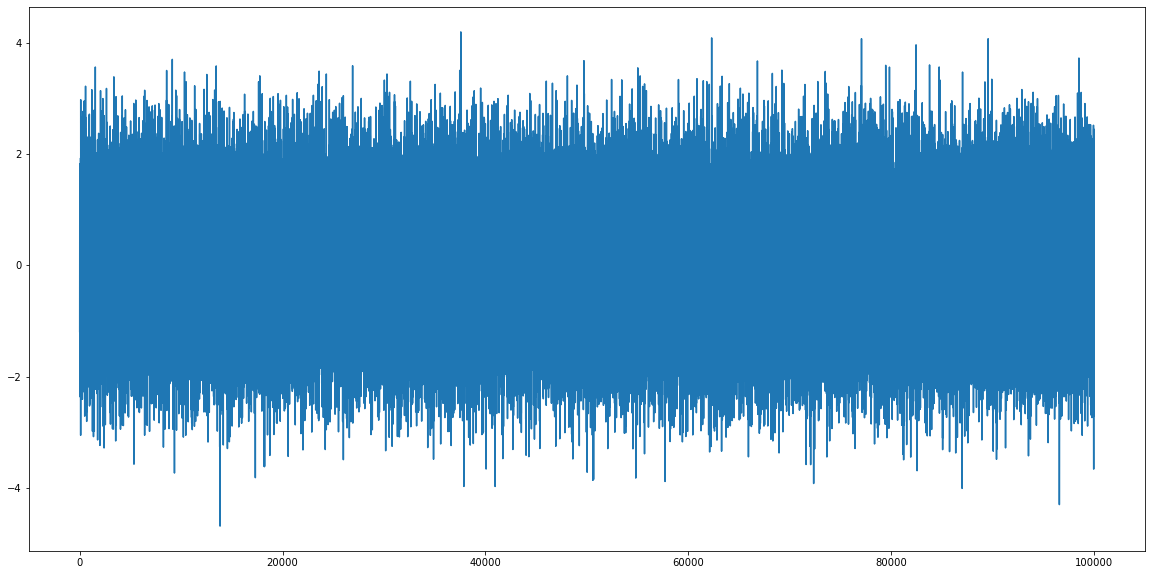

3 0


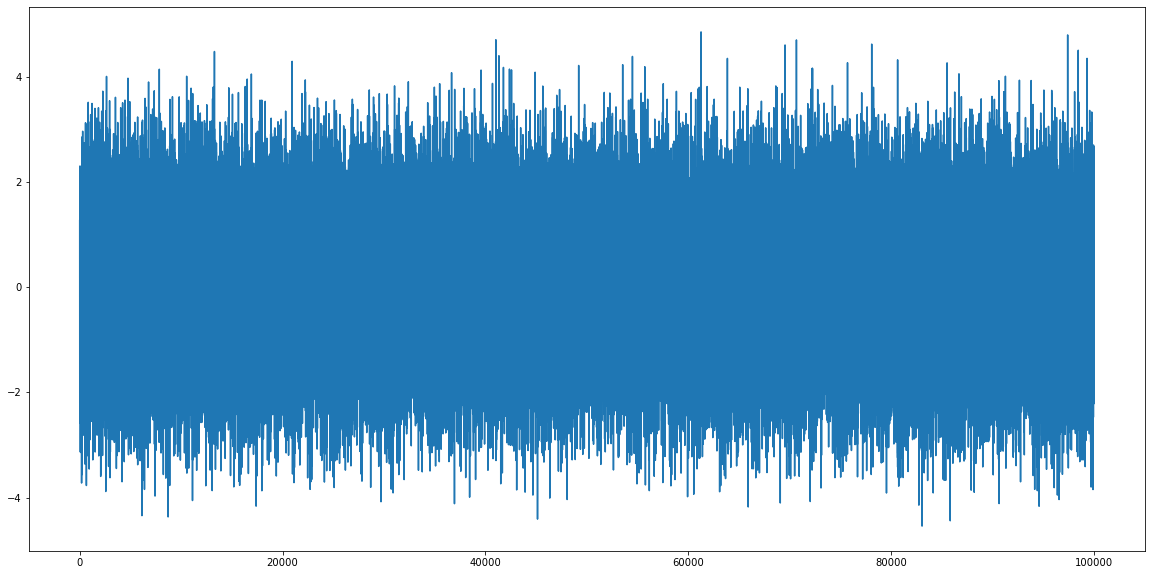

4 0


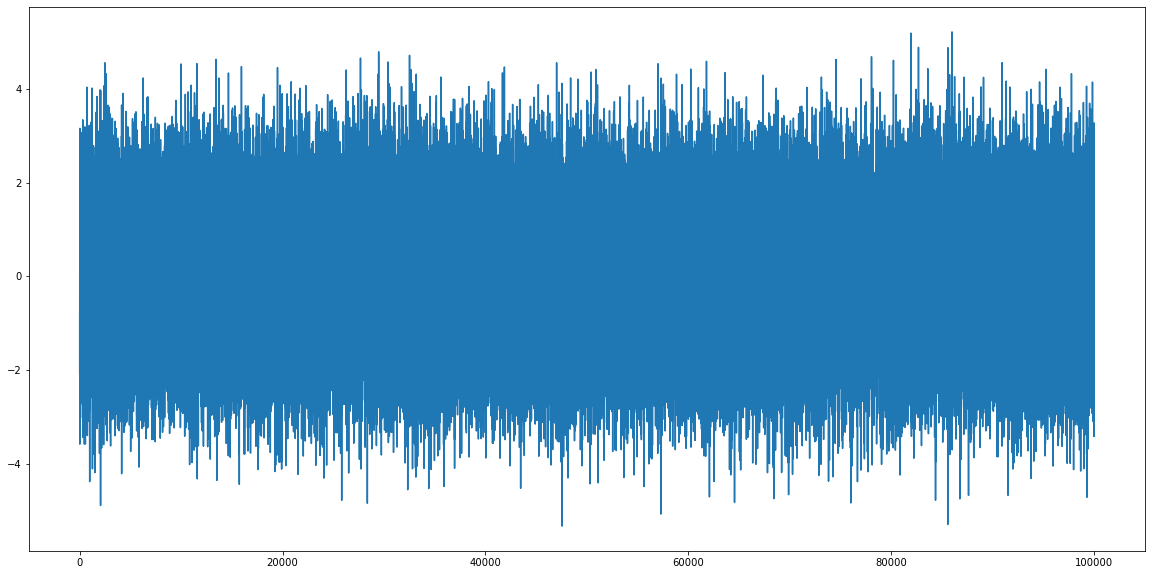

5 0


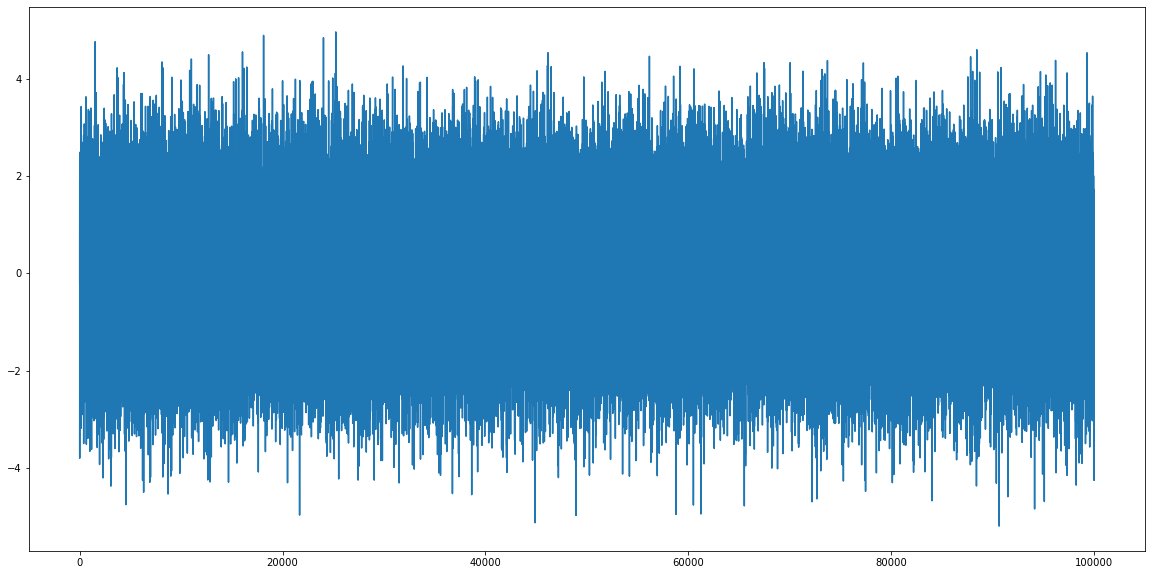

6 0


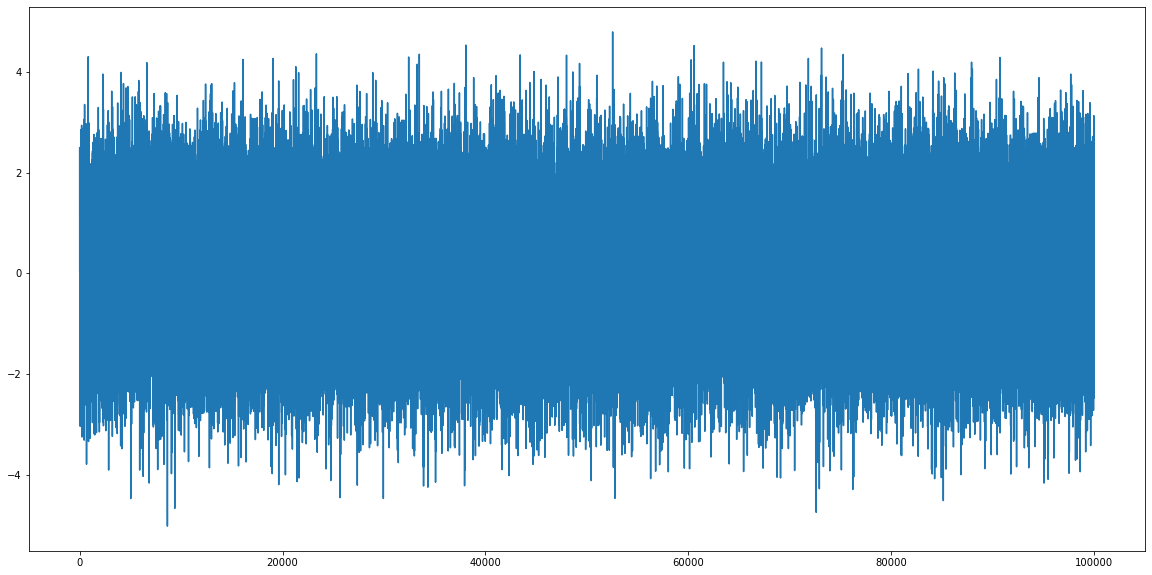

7 0


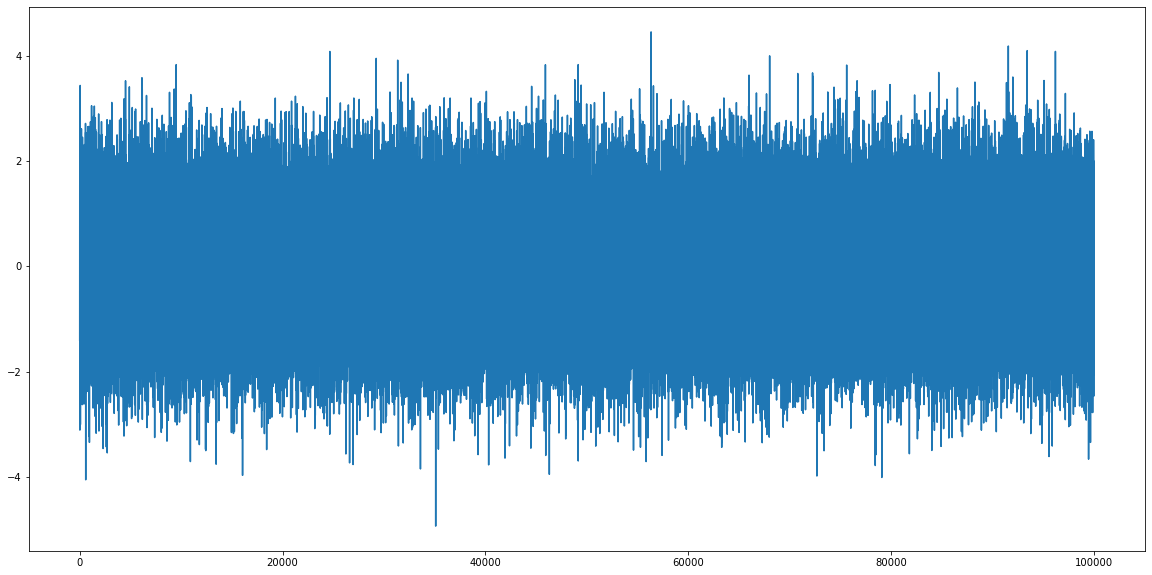

8 0


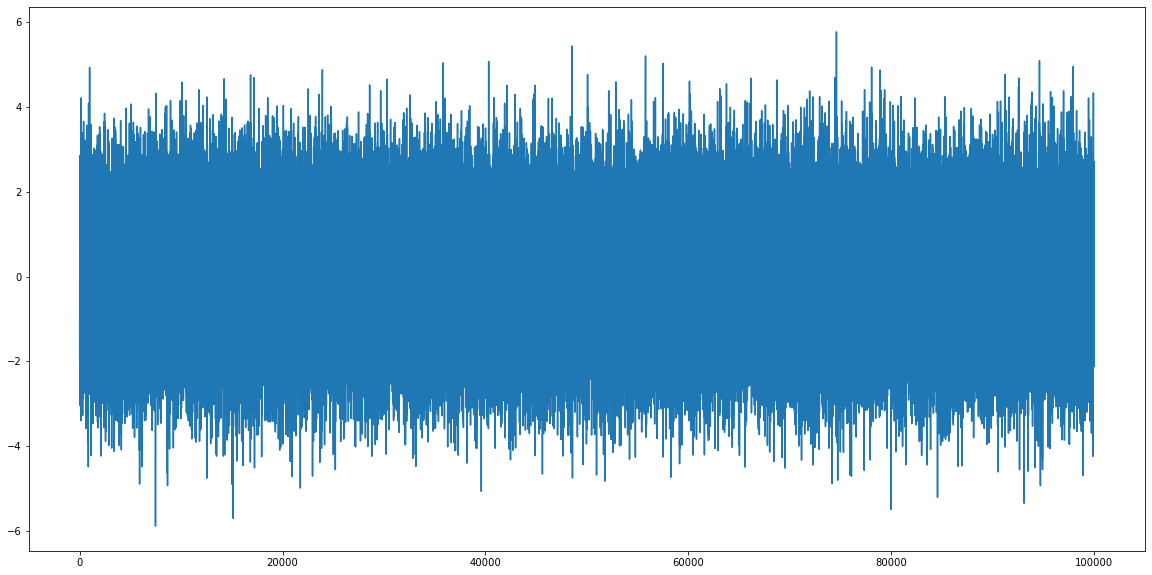

9 0


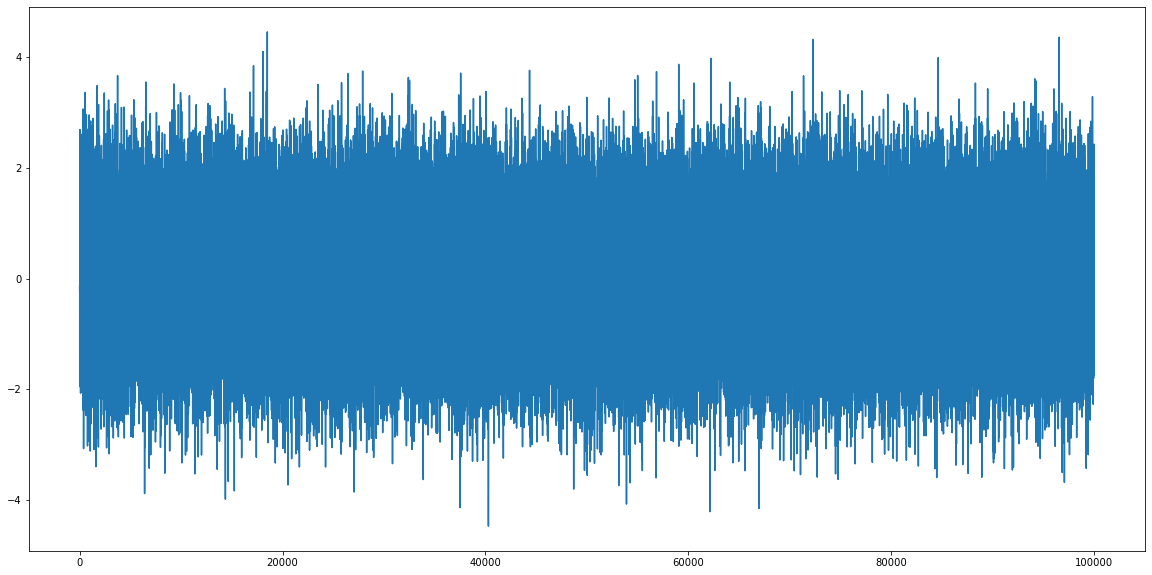

In [8]:
for i in range(len(Xs)):
    for j in range(Xs[i].shape[1]):
        plt.figure(figsize=(20, 10))
        print(i, j)
        plt.plot(Xs[i][:, j])
        plt.show()
        break

### Obtained equations

In [9]:
print("Equations obtained")
for k in range(len(configs)):
    print("Case ", k+1)
    for key in configs[k][0].keys():
        eq = "X{} = ".format(key)
        for  regr, ts, sign,  coef in zip(configs[k][0][key], configs[k][1][key],
                                         configs[k][2][key], configs[k][3][key]):
            if(sign == 1):
                eq += "+"
            eq += str(sign*round(coef, 3)) + "X{}".format(regr) + "[t-{}]".format(ts) + " "
        eq += "+ n~N(0, 1)"
        print(eq)
        print("")

Equations obtained
Case  1
X0 = +0.129X7[t-249] -0.104X1[t-206] +0.374X4[t-55] -0.334X0[t-140] +0.341X2[t-89] + n~N(0, 1)

X1 = +0.235X1[t-182] +0.129X4[t-205] +0.149X2[t-122] -0.399X6[t-77] + n~N(0, 1)

X2 = -0.012X8[t-184] +0.106X7[t-200] + n~N(0, 1)

X3 = -0.312X6[t-140] -0.374X8[t-246] -0.035X9[t-136] -0.375X7[t-165] +0.072X1[t-60] -0.341X3[t-182] +0.209X4[t-174] +0.162X2[t-5] + n~N(0, 1)

X4 = -0.078X4[t-164] +0.201X3[t-213] -0.187X2[t-147] -0.037X1[t-89] + n~N(0, 1)

X5 = -0.239X8[t-78] -0.269X6[t-197] +0.254X5[t-187] +0.37X2[t-179] +0.1X1[t-69] +0.383X3[t-77] -0.073X9[t-84] +0.253X0[t-152] + n~N(0, 1)

X6 = +0.123X2[t-196] +0.241X5[t-152] + n~N(0, 1)

X7 = -0.267X6[t-221] -0.393X1[t-220] -0.286X4[t-151] -0.075X7[t-126] -0.256X9[t-247] +0.014X0[t-44] + n~N(0, 1)

X8 = +0.157X9[t-43] -0.185X3[t-73] +0.399X4[t-180] +0.199X7[t-131] -0.385X8[t-210] +0.355X0[t-21] + n~N(0, 1)

X9 = +0.103X2[t-86] +0.052X7[t-42] +0.126X1[t-2] + n~N(0, 1)

Case  2
X0 = -0.224X7[t-109] -0.353X1[t-124] +0

### Calculating dependencies for  randomly chosen targets

In [10]:
class IMVTensorLSTM(torch.jit.ScriptModule):
    
    __constants__ = ["n_units", "input_dim"]
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_i = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_f = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_o = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_i = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_f = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_o = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_i = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_f = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_o = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    
    @torch.jit.script_method
    def forward(self, x):
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            # eq 1
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            # eq 5
            i_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_i) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_i) + self.b_i)
            f_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_f) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_f) + self.b_f)
            o_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_o) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_o) + self.b_o)
            # eq 6
            c_tilda_t = c_tilda_t*f_tilda_t + i_tilda_t*j_tilda_t
            # eq 7
            h_tilda_t = (o_tilda_t*torch.tanh(c_tilda_t))
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        # eq 8
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n) +self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)
        
        return mean.squeeze(1)

In [11]:
depth = 300
epochs = 100
importance_calculation_steps = 20
early_stopping_epochs = 10

regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [12]:
maps = []
results = []

In [13]:
from tqdm import tqdm_notebook

In [14]:
for k in range(len(Xs)):
    print("Case: ", k+1)
    X = np.zeros((length, depth, Xs[k].shape[1]))
    for i in tqdm_notebook(range(Xs[k].shape[1])):
        for j in range(depth):
            X[:, j, i] = pd.Series(Xs[k][:, i]).shift(depth - j - 1).bfill()
    
    y = pd.Series(Xs[k][:, targets[k]]).shift(-1).ffill().values
    
    X_train = X[:train_length]
    X_test = X[train_length:]
    y_train = y[:train_length]
    y_test = y[train_length:]
    
    X_train_t = torch.Tensor(X_train)
    X_test_t = torch.Tensor(X_test)
    y_train_t = torch.Tensor(y_train)
    y_test_t = torch.Tensor(y_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)
    
    #model = TCNModel(X_train_t.shape[2], num_channels=[32] * 9, kernel_size=3, dropout=0.0).cuda()
    #model = GRUnet(X_train_t.shape[2], n_units=128).cuda()
    model = IMVTensorLSTM(X_train_t.shape[2], 1, 64).cuda()

    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.8)
    loss = nn.MSELoss()
    
    
    val_loss = 999
    counter = 0
    
    print("Training")
    for e in range(epochs):
        train_loss = 0
        model.train()
        for batch_x, batch_y in tqdm_notebook(train_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            output = model(batch_x)
            l = loss(output, batch_y)
            l.backward()
            opt.step()
            train_loss+=l.item()*batch_x.shape[0]
        true = []
        preds = []
        model.eval()
        sc.step()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.cuda()
                output = model(batch_x)
                true.append(batch_y.numpy())
                preds.append(output.detach().cpu().numpy())
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        mse = mean_squared_error(true, preds)
        r2 = r2_score(true, preds)
        print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
        if val_loss > mse:
            val_loss = mse
            torch.save(model.state_dict(), "imvlstm_{}.pt".format(k))
        else:
            counter += 1
        
        if counter == early_stopping_epochs:
            break
    model.load_state_dict(torch.load('imvlstm_{}.pt'.format(k)))
    
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    model.train()
    
    print("Calculating Importance:")
    importance_map = []
    for batch_x, batch_y in tqdm_notebook(test_loader):
        batch_x = batch_x.cuda()
        #batch_y = batch_y.cuda()
        bx = batch_x
        y = model(batch_x)
        mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
        opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
        for e in range(importance_calculation_steps):
            opt.zero_grad()
            model.zero_grad()
            #model.eval()
            y = y.detach()
            M = torch.sigmoid(mask)
            x_hat = bx*M
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff1*torch.sum(torch.abs(M))
            ones = torch.zeros_like(bx)
            ones[M>0.5] = 1
            l += 0.5*bce_loss(M, ones)
            l.backward()
            opt.step()
        M = torch.sigmoid(mask)
        #ms = ms.detach().cpu().numpy()
        thresholds = {}
        with torch.no_grad():
            for t in np.linspace(M.min().item(), M.max().item(), 100):
                M_clone = M.clone()
                M_clone[M_clone>t] = 1
                M_clone[M_clone<=t] = 0
                x_hat = bx*M_clone
                y_hat = model(x_hat)
                l = mse_loss(y_hat, y)
                l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
                thresholds[l.item()] = t
        t = thresholds[min(thresholds.keys())]
        M = M.detach().cpu().numpy()
        M[M>t] = 1
        M[M<=t] = 0
        importance_map.append(np.abs(M))
        
    importance_map = np.concatenate(importance_map)
    importance_map = np.mean(importance_map, axis=0)
    
    maps.append(importance_map)
    result = {}
    for i in range(importance_map.shape[1]):
        max_val = importance_map[:, i].max()
        if max_val > importance_threshold:
            timestep = importance_map.shape[0] - np.argmax(importance_map[:, i])
            result[i] = timestep
    
    FP, TP, FN = 0, 0, 0
    for regr, ts in zip(configs[k][0][targets[k]], configs[k][1][targets[k]]):
        predicted_timestep = result.get(regr)
        if predicted_timestep is None:
            FN += 1
        elif predicted_timestep != ts:
            FP += 1
            FN += 1
        else:
            TP += 1

    for regr in result.keys():
        if regr not in configs[k][0][targets[k]]:
            FP += 1
            
    precision = TP/(TP + FP + 1e-9)
    recall = TP/(TP + FN + 1e-9)
    print("Results: ", precision, recall)
    results.append([precision, recall])

Case:  1


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.8390389728546142 mse:  1.8387222 r2:  0.0027649750907590143


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.8354740545272827 mse:  1.8364809 r2:  0.0039806686976539


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.8313701248168945 mse:  1.8368859 r2:  0.0037609270973449904


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.8268416962146758 mse:  1.8341187 r2:  0.005261636244817014


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.8232669451713561 mse:  1.835627 r2:  0.004443768014841587


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.821934352493286 mse:  1.8301504 r2:  0.007413907468945324


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.816297497177124 mse:  1.8260293 r2:  0.009649160359599729


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.814050367975235 mse:  1.8269242 r2:  0.009163650647945887


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.8129112290859222 mse:  1.8240432 r2:  0.010726227611423611


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.812075080537796 mse:  1.8304859 r2:  0.007232056275283227


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.8108077920913697 mse:  1.8251935 r2:  0.0101023235120965


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.8102496778964996 mse:  1.828739 r2:  0.008179431611468613


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.8099984121322632 mse:  1.8250176 r2:  0.0101977577948279


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.8088863646507263 mse:  1.8272932 r2:  0.008963557431951985


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.8085496120452882 mse:  1.8272381 r2:  0.008993478910937713


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  15 train:  1.8074406361579896 mse:  1.8264502 r2:  0.009420760664663796
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.9999999989999999 0.124999999984375
Case:  2


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.1982514241218567 mse:  1.2111235 r2:  0.00028366033768290055


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.1977774871826172 mse:  1.211259 r2:  0.00017177072688046024


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.1976914499282838 mse:  1.211481 r2:  -1.13930769614079e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.197613440990448 mse:  1.2131453 r2:  -0.0013852961771876338


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1976481578826905 mse:  1.2116969 r2:  -0.00018955916788909732


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.1973453249454498 mse:  1.21194 r2:  -0.00039036915386603255


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.197033098936081 mse:  1.2122803 r2:  -0.0006712354693341194


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.196943762922287 mse:  1.2118286 r2:  -0.00029843583006972096


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.1968758978366851 mse:  1.212058 r2:  -0.00048770224076322144


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.1966227123260498 mse:  1.2112726 r2:  0.00016052014337719633


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1961750455856324 mse:  1.2123271 r2:  -0.0007098594092722621
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  3


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.6124092212200165 mse:  1.6060672 r2:  0.00162279024874179


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.6098826387405396 mse:  1.6048648 r2:  0.002370219518752603


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.6087260834217072 mse:  1.6070178 r2:  0.001031793694664107


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.6101889791965485 mse:  1.6083424 r2:  0.00020846144345176842


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.610472136116028 mse:  1.6100303 r2:  -0.0008408258000076607


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.609560080575943 mse:  1.6071957 r2:  0.0009211579100479872


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.608391801595688 mse:  1.6046559 r2:  0.0025000494473430557


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.608024666118622 mse:  1.6063293 r2:  0.0014598078875377452


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.6070218431472778 mse:  1.6045258 r2:  0.0025808830915585723


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.6062461256980896 mse:  1.6041819 r2:  0.0027946916665446686


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.6053193250179292 mse:  1.6051134 r2:  0.002215654440513637


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.6044576716899872 mse:  1.6047322 r2:  0.002452586908058607


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.6065589743614197 mse:  1.6096065 r2:  -0.0005774825978610565


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.6063586539268493 mse:  1.6070697 r2:  0.0009994738522568491


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.6058522024154662 mse:  1.6083046 r2:  0.0002318642979347585
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  4


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.1416411127567292 mse:  1.1292592 r2:  0.010524142167581574


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.134385879468918 mse:  1.1241436 r2:  0.015006602928999468


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.1313650852680206 mse:  1.124022 r2:  0.015113127185168329


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.1310301168441772 mse:  1.1246662 r2:  0.014548698738027444


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1311169287204743 mse:  1.1235349 r2:  0.015539914535449895


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.130951023197174 mse:  1.1248701 r2:  0.014370060233134474


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.1305541751384736 mse:  1.1246516 r2:  0.014561590192890717


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.1304554523468018 mse:  1.1244487 r2:  0.014739342645665676


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.1302098343849183 mse:  1.1247867 r2:  0.014443153334822711


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.1300332111358642 mse:  1.125508 r2:  0.013811117954250496


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1295223168849946 mse:  1.1242158 r2:  0.01494332887456129


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.1292641260623932 mse:  1.1243657 r2:  0.014811949259170731


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.1288091070652009 mse:  1.1249503 r2:  0.014299756971528743


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.1288344845294953 mse:  1.1251887 r2:  0.014090881215303552
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  5


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.0004637674808503 mse:  1.002783 r2:  4.577764930058237e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  0.9999290286064147 mse:  1.0029054 r2:  -7.633004318363668e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  0.999635876750946 mse:  1.003214 r2:  -0.00038406107931177047


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  0.9993919357776642 mse:  1.0032095 r2:  -0.0003795619942261741


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  0.9993338995456695 mse:  1.003268 r2:  -0.00043789593374632396


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  0.9992593199253083 mse:  1.0034393 r2:  -0.0006088399066068728


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  0.9991926301002503 mse:  1.0043889 r2:  -0.0015557296627630723


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  0.9997361220598221 mse:  1.0049738 r2:  -0.002138910497306634


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  0.9992688244819641 mse:  1.0051422 r2:  -0.0023068855854189163


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  0.9991181598186493 mse:  1.0042254 r2:  -0.0013925064589828118


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  0.9987199719905854 mse:  1.0044607 r2:  -0.0016273494075293993
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  6


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.3942035140514373 mse:  1.4055139 r2:  -6.875783351945053e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.3939872359275818 mse:  1.4055104 r2:  -6.630757096415252e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.3937722917556763 mse:  1.4059727 r2:  -0.00039525460973033333


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.393616234588623 mse:  1.4058926 r2:  -0.0003381897989793714


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.3933198642730713 mse:  1.4070871 r2:  -0.00118817761513057


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.3931366230010986 mse:  1.4071926 r2:  -0.0012631850201736405


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.3930590782642365 mse:  1.406586 r2:  -0.0008316417508380525


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.3928492347717285 mse:  1.408797 r2:  -0.002404814723257598


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.392817294216156 mse:  1.4062201 r2:  -0.0005712319124582255


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.3925555993080139 mse:  1.4080503 r2:  -0.0018734771987716226


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.3920293017864227 mse:  1.407019 r2:  -0.0011396409434025756


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.3913313679218293 mse:  1.4072639 r2:  -0.0013138678131872084
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  7


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.1273618763446809 mse:  1.1246914 r2:  -7.52027163839486e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.127223064661026 mse:  1.1247966 r2:  -0.0001689207398742898


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.1272382189750672 mse:  1.1246746 r2:  -6.029668072726757e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.12716218957901 mse:  1.1246073 r2:  -5.017298716492036e-07


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1271436155319214 mse:  1.1246868 r2:  -7.11943416333849e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.1273387382507325 mse:  1.124616 r2:  -8.276719128508248e-06


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.1270833889961243 mse:  1.1244262 r2:  0.00016053800789161965


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.1270188070774079 mse:  1.1247776 r2:  -0.00015179900688933046


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.126921170568466 mse:  1.1243124 r2:  0.0002617389140404658


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.1271014679431914 mse:  1.124624 r2:  -1.5365718346593837e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1270164320468903 mse:  1.1245612 r2:  4.0709404793393134e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.1270418632507324 mse:  1.124475 r2:  0.00011720979235207984


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.1268765472888946 mse:  1.1244688 r2:  0.0001227710991558162


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.126865514755249 mse:  1.1245013 r2:  9.376389744453206e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.126543984746933 mse:  1.124922 r2:  -0.00028034573638535676
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  8


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.6312416519165038 mse:  1.6082599 r2:  0.0018506836057468057


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.628313340473175 mse:  1.6071647 r2:  0.0025304142298679944


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.6273700455665587 mse:  1.6073091 r2:  0.002440851229119967


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.628471302127838 mse:  1.6064631 r2:  0.002965867348362461


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.625283886384964 mse:  1.6034019 r2:  0.004865838459263361


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.6221372220516206 mse:  1.6019852 r2:  0.0057449726890203


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.620763616847992 mse:  1.5975063 r2:  0.00852489463838102


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.620453918981552 mse:  1.600046 r2:  0.006948495169617708


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.620273908805847 mse:  1.6000462 r2:  0.0069484597206945775


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.6199390407562255 mse:  1.6005236 r2:  0.006652209528160591


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.6202100038528442 mse:  1.6007236 r2:  0.006528060815880976


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.6194056421756744 mse:  1.6009744 r2:  0.0063723696138416885


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.618927937889099 mse:  1.6015705 r2:  0.006002451293371069


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.6197241924762726 mse:  1.6035982 r2:  0.004743937601078163


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.619256631374359 mse:  1.602656 r2:  0.005328650528204748


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  15 train:  1.6189092905521394 mse:  1.602521 r2:  0.005412453525004746
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  9


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.970110582447052 mse:  1.9528736 r2:  -0.0010156335946860384


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.9688154809951781 mse:  1.9513153 r2:  -0.00021685847060837204


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.9684379160404206 mse:  1.9509363 r2:  -2.265267018608519e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.9678080652713776 mse:  1.9512047 r2:  -0.000160181480399757


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.9677635206222535 mse:  1.9506077 r2:  0.0001458315872412408


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.9671288990974427 mse:  1.9513555 r2:  -0.00023751759732637545


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.9671363566875457 mse:  1.9517193 r2:  -0.00042397988569442546


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.9665610189437865 mse:  1.950909 r2:  -8.600038872819127e-06


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.9669765307426452 mse:  1.9468251 r2:  0.0020846691239059245


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.960723856830597 mse:  1.95315 r2:  -0.0011573637750512678


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.965317515850067 mse:  1.9519728 r2:  -0.0005539147057964655


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.9577900149345397 mse:  1.9383105 r2:  0.006449265563875151


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.9441995603561402 mse:  1.9187828 r2:  0.016458738865347322


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.9208772448539735 mse:  1.9029799 r2:  0.024559177788509245


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.916849457359314 mse:  1.9259666 r2:  0.012776486604530124


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  15 train:  1.9100278961658477 mse:  1.8811727 r2:  0.03573731201059205


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  16 train:  1.879949486875534 mse:  1.8696754 r2:  0.041630527421101515


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  17 train:  1.8643525635242462 mse:  1.8458925 r2:  0.05382131589302952


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  18 train:  1.8560174173355102 mse:  1.8436164 r2:  0.054988063875089366


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  19 train:  1.85123446559906 mse:  1.8358287 r2:  0.05897999766038231


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  20 train:  1.8407170313835144 mse:  1.826918 r2:  0.06354746063270422


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  21 train:  1.8260896527290345 mse:  1.8136157 r2:  0.07036603332029978


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  22 train:  1.8201868108272552 mse:  1.8168654 r2:  0.06870022926424102


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  23 train:  1.8035578100204468 mse:  1.7998319 r2:  0.07743135527775358


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  24 train:  1.7871251415252685 mse:  1.7929103 r2:  0.08097926236439212


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  25 train:  1.7723060970783233 mse:  1.7770152 r2:  0.08912688637925525


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  26 train:  1.7614798857688905 mse:  1.767795 r2:  0.09385302026406472


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  27 train:  1.7520761058330536 mse:  1.7563367 r2:  0.09972638259878619


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  28 train:  1.7495152825355529 mse:  1.7562693 r2:  0.09976098253969279


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  29 train:  1.740909381532669 mse:  1.7534391 r2:  0.10121170137318092


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  30 train:  1.8400788424491883 mse:  1.9144543 r2:  0.018677583699754363


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  31 train:  1.8975158306121827 mse:  1.8916223 r2:  0.03038093494741534
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.1428571428367347 0.09090909090082644
Case:  10


<ipython-input-14-0d82e3ab4420>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.3444835285663606 mse:  1.3434193 r2:  -0.000540854599548668


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.345073899078369 mse:  1.3439766 r2:  -0.0009558358916048615


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.3443870311260224 mse:  1.3429983 r2:  -0.00022721293639360596


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.3441898465156554 mse:  1.3427217 r2:  -2.1196209819107636e-05


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.3442462868213654 mse:  1.3440549 r2:  -0.001014178539478383


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.3438280734062196 mse:  1.3434916 r2:  -0.0005946880574141389


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.3432539038658142 mse:  1.3439927 r2:  -0.000967830751075871


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.3429793366909026 mse:  1.3438451 r2:  -0.0008577790313799571


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.3429366497039794 mse:  1.3453791 r2:  -0.0020003320931420987


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.3425496625900268 mse:  1.3442086 r2:  -0.0011285573132195914


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.342008318042755 mse:  1.3443028 r2:  -0.0011987666193502555


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.3416755381584167 mse:  1.3447932 r2:  -0.0015639622380843043


<ipython-input-14-0d82e3ab4420>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.341197703075409 mse:  1.3459481 r2:  -0.002424084601782006
Calculating Importance:


<ipython-input-14-0d82e3ab4420>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0


In [18]:
for i, r in enumerate(results):
    print('Case {}'.format(i+1))
    print('Precision', 'Recall')
    print(r)

Case 1
Precision Recall
[0.9999999989999999, 0.124999999984375]
Case 2
Precision Recall
[0.0, 0.0]
Case 3
Precision Recall
[0.0, 0.0]
Case 4
Precision Recall
[0.0, 0.0]
Case 5
Precision Recall
[0.0, 0.0]
Case 6
Precision Recall
[0.0, 0.0]
Case 7
Precision Recall
[0.0, 0.0]
Case 8
Precision Recall
[0.0, 0.0]
Case 9
Precision Recall
[0.1428571428367347, 0.09090909090082644]
Case 10
Precision Recall
[0.0, 0.0]


### Visual estimation of resulted importance heatmaps

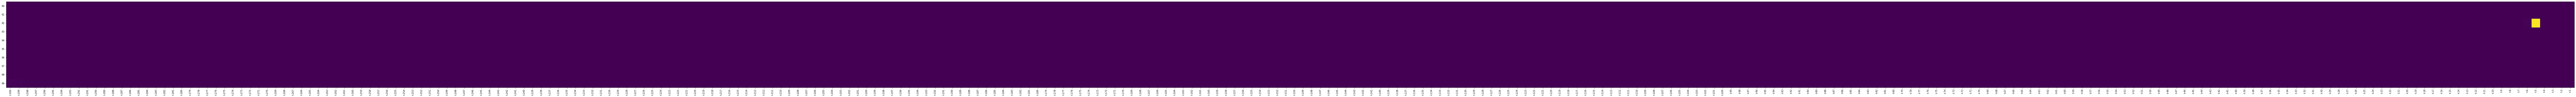

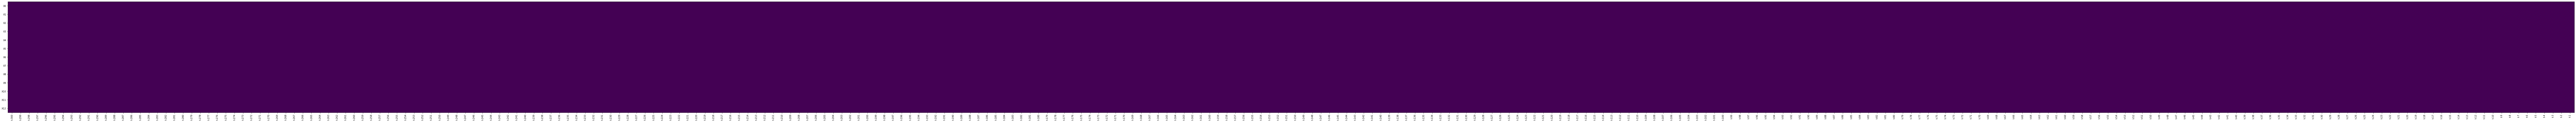

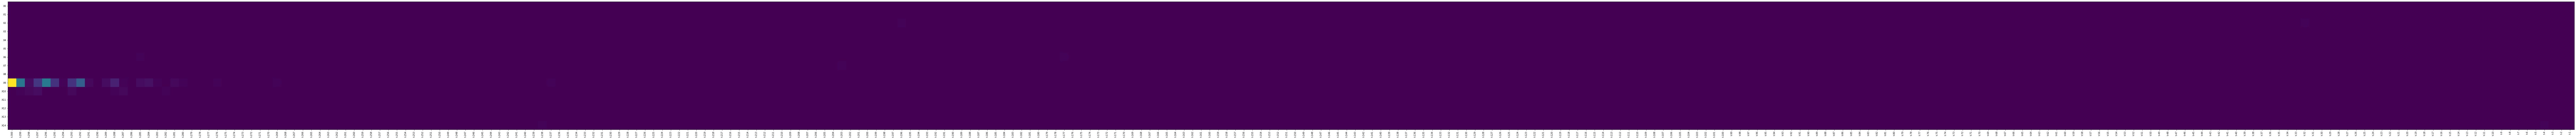

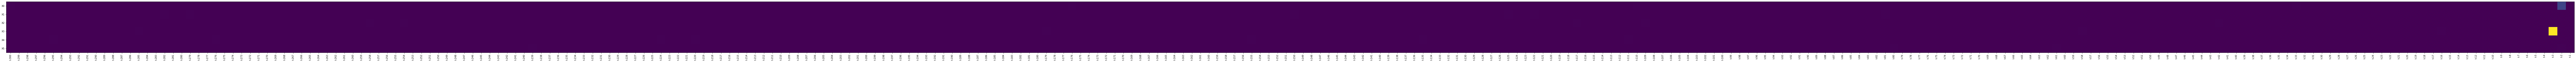

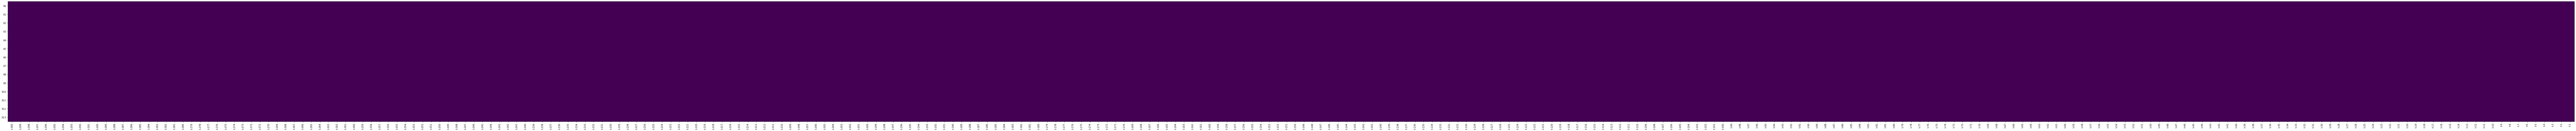

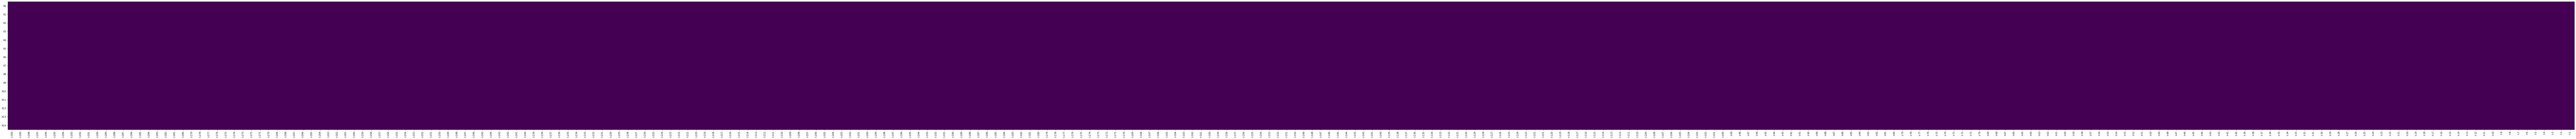

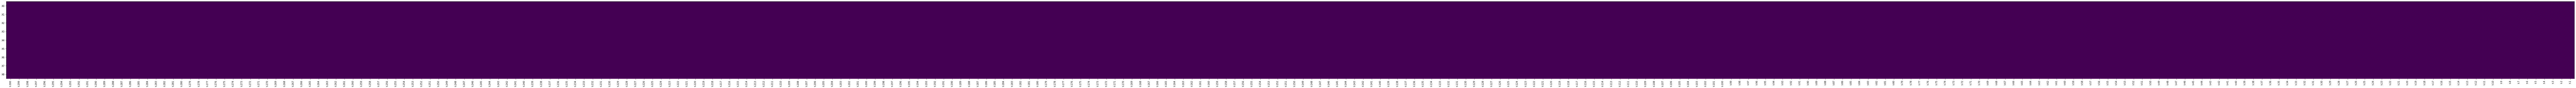

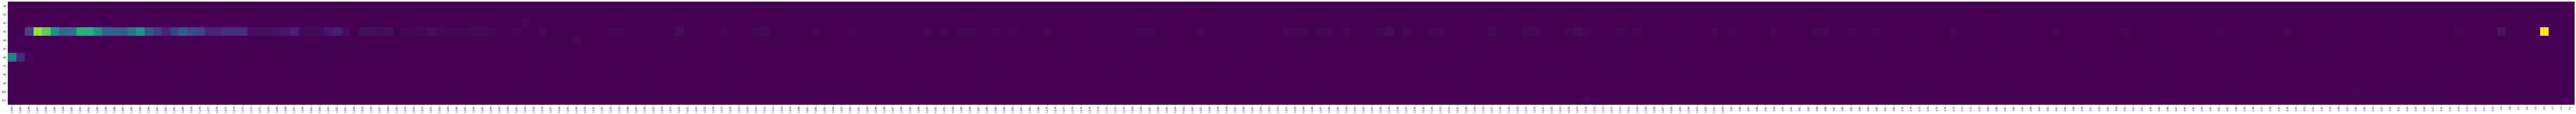

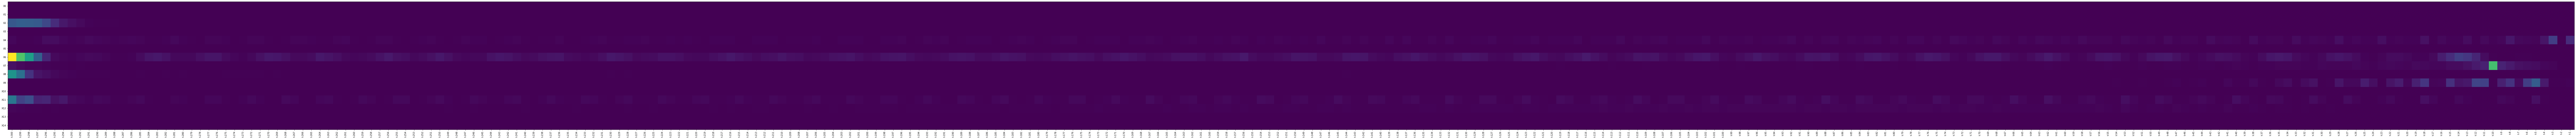

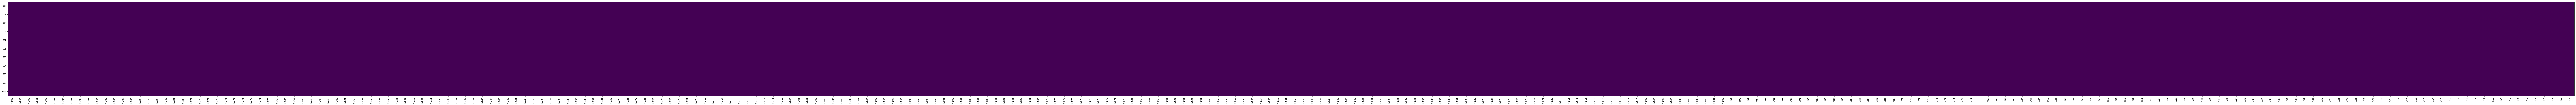

In [19]:
for i in range(number_of_experiments):
    fig, ax = plt.subplots(figsize=(200, 100))
    ax.imshow(maps[i].T)
    ax.set_xticks(np.arange(depth))
    ax.set_xticklabels(["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
    ax.set_yticks(np.arange(Xs[i].shape[1]))
    ax.set_yticklabels(["X{}".format(i) for i in range(Xs[i].shape[1])])
    plt.show()